In [1]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
import scipy
from scipy import misc
import skimage
from skimage import transform
import os

Using TensorFlow backend.


In [2]:
shape = (96, 96, 3)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np.squeeze(y_train) #get (50000, ) instead of (50000, 1)
print('data loaded')

data loaded


In [3]:
model = MobileNetV2(weights='imagenet', include_top=False,
                   input_shape=shape)
print('model loaded')

model loaded


In [4]:
path = '/home/bkuehnis/Documents/'
filename = 'mnv2_fatures_train.npz'
#optain train features, read from file if already gotten
if os.path.exists(path + filename):
    print('features detected (train)')
    features = np.load(path + filename)['features']
else:
    print('features file not detected (train)')
    print('calc')
    big_x_train = np.array([scipy.misc.imresize(x_train[i], shape) 
                            for i in range(0, len(x_train))]).astype('float32')
    mnv2_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    features = model.predict(mnv2_input_train, verbose=1)
    features = np.squeeze(features)
    
    np.savez(path+filename, features=features)
    print('saved features')

print('features ready (train)')
print(features.shape)

features detected (train)
features ready (train)
(50000, 3, 3, 1280)


In [5]:
filename_test = 'mnv2_fatures_test.npz'

if os.path.exists(path + filename_test):
    print('features detected (test)')
    features_test = np.load(path + filename_test)['features_test']
else:
    print('features file not detected (train)')
    print('calc')
    big_x_test = np.array([scipy.misc.imresize(x_test[i], shape) 
                            for i in range(0, len(x_test))]).astype('float32')
    mnv2_input_test = preprocess_input(big_x_test)
    print('test data preprocessed')
    features_test = model.predict(mnv2_input_test, verbose=1)
    features_test = np.squeeze(features_test)
    
    np.savez(path+filename_test, features_test=features_test)
    print('saved features')

print('features ready (test)')
print(features_test.shape)

features detected (test)
features ready (test)
(10000, 3, 3, 1280)


In [6]:
print('using inpit shape (output shape of model)', model.output_shape[1:])
n_classes = 10

mlp = Sequential()
mlp.add(Conv2D(filters=128, kernel_size=1, strides=1, input_shape=model.output_shape[1:]))
mlp.add(Flatten())
mlp.add(Dense(10*n_classes, activation='relu'))
mlp.add(Dense(n_classes, activation='softmax'))
mlp.summary()


using inpit shape (output shape of model) (3, 3, 1280)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 128)         163968    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 280,278
Trainable params: 280,278
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

B = 128
E = 10
mlp.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
log = mlp.fit(features,Y_train,batch_size=B,epochs=E,verbose=1,validation_data=(features_test,Y_test))

(50000, 3, 3, 1280)
(10000, 3, 3, 1280)
(50000,)
(10000, 1)
(50000, 10)
(10000, 10)
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 142us/step - loss: 0.5513 - acc: 0.8157 - val_loss: 0.4600 - val_acc: 0.8427
Epoch 2/10
50000/50000 [==============================] - 6s 112us/step - loss: 0.3347 - acc: 0.8852 - val_loss: 0.4500 - val_acc: 0.8514
Epoch 3/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.2521 - acc: 0.9112 - val_loss: 0.4647 - val_acc: 0.8550
Epoch 4/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.1915 - acc: 0.9337 - val_loss: 0.5347 - val_acc: 0.8472
Epoch 5/10
50000/50000 [==============================] - 6s 113us/step - loss: 0.1542 - acc: 0.9462 - val_loss: 0.5309 - val_acc: 0.8479
Epoch 6/10
50000/50000 [==============================] - 6s 112us/step - loss: 0.1210 - acc: 0.9570 - val_loss: 0.5683 - val_acc: 0.8573
Epoch 7/10
50000/50000 [==============

In [15]:
from matplotlib import pyplot as pl

pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

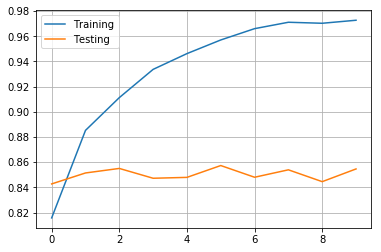

In [16]:
pl.plot(log.history['acc'], label='Training')
pl.plot(log.history['val_acc'], label='Testing')
pl.legend()
pl.grid()

In [17]:
loss_train, metric_train = mlp.evaluate(features, Y_train, verbose=1)
loss_test, metric_test = mlp.evaluate(features_test, Y_test, verbose=1)

print('Train accuracy:', metric_train)
print('Test accuracy:', metric_test)

10000/10000 [==============================] - 1s 111us/step
Train accuracy: 0.98546
Test accuracy: 0.8546


## Using Data augmentation

This method is rly slow (I aborted it). The question is why. TODO ask next week.

In [20]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8,
                         width_shift_range=0.08,
                         shear_range=0.3,
                         height_shift_range=0.08,
                         zoom_range=0.08)

batches = gen.flow(features,Y_train,batch_size=B)
val_batches = gen.flow(features_test,Y_test,batch_size=B)

/home/bkuehnis/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (10000, 3, 3, 1280) (1280 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [21]:
mlp2 = Sequential()
mlp2.add(Conv2D(filters=128, kernel_size=1, strides=1, input_shape=model.output_shape[1:]))
mlp2.add(Flatten())
mlp2.add(Dense(10*n_classes, activation='relu'))
mlp2.add(Dense(n_classes, activation='softmax'))
mlp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 3, 128)         163968    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               115300    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 280,278
Trainable params: 280,278
Non-trainable params: 0
_________________________________________________________________


In [22]:
mlp2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
log2 = mlp2.fit_generator(batches,steps_per_epoch=50000//128,
                        epochs=E,
                        validation_data=val_batches,
                        validation_steps=10000//128,
                        use_multiprocessing=True)

Epoch 1/10
390/390 [==============================] - 750s 2s/step - loss: 0.5542 - acc: 0.8137 - val_loss: 0.4302 - val_acc: 0.8554
Epoch 2/10
390/390 [==============================] - 726s 2s/step - loss: 0.3544 - acc: 0.8786 - val_loss: 0.4355 - val_acc: 0.8542
Epoch 3/10
390/390 [==============================] - 728s 2s/step - loss: 0.2824 - acc: 0.9013 - val_loss: 0.4051 - val_acc: 0.8667
Epoch 4/10
390/390 [==============================] - 725s 2s/step - loss: 0.2338 - acc: 0.9183 - val_loss: 0.4664 - val_acc: 0.8564
Epoch 5/10
390/390 [==============================] - 723s 2s/step - loss: 0.1913 - acc: 0.9325 - val_loss: 0.4955 - val_acc: 0.8577
Epoch 6/10
390/390 [==============================] - 723s 2s/step - loss: 0.1556 - acc: 0.9446 - val_loss: 0.5392 - val_acc: 0.8585
Epoch 7/10
390/390 [==============================] - 731s 2s/step - loss: 0.1285 - acc: 0.9542 - val_loss: 0.6361 - val_acc: 0.8528
Epoch 8/10
390/390 [==============================] - 723s 2s/step - 

In [23]:
loss_train, metric_train = mlp2.evaluate(features, Y_train, verbose=1)
loss_test, metric_test = mlp2.evaluate(features_test, Y_test, verbose=1)

print('Train accuracy:', metric_train)
print('Test accuracy:', metric_test)

10000/10000 [==============================] - 1s 113us/step
Train accuracy: 0.98486
Test accuracy: 0.854
